# Standalone DexYCB Evaluation with Standard Metrics

This notebook provides a standalone evaluation script that doesn't require the full model infrastructure.
It loads predictions and ground truth data to compute:
- **MPJPE**: Mean Per Joint Position Error in millimeters
- **PA-MPJPE**: Procrustes-aligned MPJPE after optimal rigid alignment
- **PCK**: Percentage of Correct Keypoints within various thresholds
- **AUC**: Area Under Curve for PCK from 0-50mm
- **Diversity**: Standard deviation of predictions to measure mode collapse

In [1]:
# Imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import json
import os
from typing import Dict, List, Tuple, Optional
import pandas as pd
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Metric computation functions

def compute_mpjpe(pred_joints: np.ndarray, gt_joints: np.ndarray) -> np.ndarray:
    """
    Compute Mean Per Joint Position Error
    
    Args:
        pred_joints: [N, 21, 3] predicted 3D joints
        gt_joints: [N, 21, 3] ground truth 3D joints
    
    Returns:
        errors: [N, 21] errors per joint per sample
    """
    errors = np.linalg.norm(pred_joints - gt_joints, axis=-1)
    return errors

def procrustes_align(pred: np.ndarray, gt: np.ndarray) -> np.ndarray:
    """
    Align predicted pose to ground truth using Procrustes analysis
    
    Args:
        pred: [21, 3] predicted joints
        gt: [21, 3] ground truth joints
    
    Returns:
        aligned: [21, 3] aligned predicted joints
    """
    # Center the points
    pred_centered = pred - pred.mean(axis=0)
    gt_centered = gt - gt.mean(axis=0)
    
    # Compute optimal rotation
    H = pred_centered.T @ gt_centered
    U, _, Vt = np.linalg.svd(H)
    R_opt = Vt.T @ U.T
    
    # Handle reflection
    if np.linalg.det(R_opt) < 0:
        Vt[-1, :] *= -1
        R_opt = Vt.T @ U.T
    
    # Apply transformation
    aligned = pred_centered @ R_opt.T
    aligned += gt.mean(axis=0)
    
    return aligned

def compute_pa_mpjpe(pred_joints: np.ndarray, gt_joints: np.ndarray) -> np.ndarray:
    """
    Compute Procrustes-aligned MPJPE
    
    Args:
        pred_joints: [N, 21, 3] predicted joints
        gt_joints: [N, 21, 3] ground truth joints
    
    Returns:
        pa_errors: [N] PA-MPJPE per sample
    """
    N = pred_joints.shape[0]
    pa_errors = np.zeros(N)
    
    for i in range(N):
        # Align prediction to ground truth
        aligned_pred = procrustes_align(pred_joints[i], gt_joints[i])
        
        # Compute error
        error = np.mean(np.linalg.norm(aligned_pred - gt_joints[i], axis=-1))
        pa_errors[i] = error
    
    return pa_errors

def compute_pck(errors: np.ndarray, thresholds: List[float]) -> Dict[str, float]:
    """
    Compute Percentage of Correct Keypoints for different thresholds
    
    Args:
        errors: [N] or [N, 21] error values
        thresholds: List of threshold values in mm
    
    Returns:
        pck_values: Dictionary with PCK values for each threshold
    """
    # If per-joint errors, take mean
    if errors.ndim > 1:
        errors = errors.mean(axis=1)
    
    pck_values = {}
    for threshold in thresholds:
        correct = (errors < threshold).mean() * 100
        pck_values[f'PCK@{threshold}mm'] = correct
    
    return pck_values

def compute_auc(errors: np.ndarray, min_threshold: float = 0, 
                max_threshold: float = 50, num_steps: int = 100) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Compute Area Under Curve for PCK metric
    
    Args:
        errors: [N] error values
        min_threshold: Minimum threshold for AUC
        max_threshold: Maximum threshold for AUC
        num_steps: Number of threshold steps
    
    Returns:
        auc: Area under curve value
        thresholds: Threshold values used
        pck_values: PCK values at each threshold
    """
    # If per-joint errors, take mean
    if errors.ndim > 1:
        errors = errors.mean(axis=1)
    
    thresholds = np.linspace(min_threshold, max_threshold, num_steps)
    pck_values = []
    
    for threshold in thresholds:
        pck = (errors < threshold).mean()
        pck_values.append(pck)
    
    # Compute AUC using trapezoidal rule
    auc = np.trapz(pck_values, thresholds) / (max_threshold - min_threshold)
    
    return auc, thresholds, np.array(pck_values)

def compute_diversity(predictions: np.ndarray) -> Dict[str, float]:
    """
    Compute prediction diversity (std deviation) to detect mode collapse
    
    Args:
        predictions: [N, 21, 3] all predictions
    
    Returns:
        diversity_metrics: Dictionary with diversity measurements
    """
    # Compute std deviation per joint
    std_per_joint = np.std(predictions, axis=0)  # [21, 3]
    mean_std = std_per_joint.mean()
    
    # Overall std (flattened)
    overall_std = np.std(predictions.reshape(predictions.shape[0], -1), axis=0).mean()
    
    # Compute pairwise distances to check for duplicate predictions
    n_samples = min(1000, len(predictions))  # Subsample for efficiency
    indices = np.random.choice(len(predictions), n_samples, replace=False)
    subset = predictions[indices].reshape(n_samples, -1)
    
    # Compute pairwise distances
    dists = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            dists[i, j] = np.linalg.norm(subset[i] - subset[j])
            dists[j, i] = dists[i, j]
    
    # Get minimum distance to another prediction (excluding self)
    np.fill_diagonal(dists, np.inf)
    min_dists = dists.min(axis=1)
    
    return {
        'mean_std_per_joint': mean_std,
        'overall_std': overall_std,
        'std_per_joint': std_per_joint,
        'mean_min_distance': min_dists.mean(),
        'min_min_distance': min_dists.min()
    }

In [3]:
# Generate sample data for demonstration
# In practice, replace this with loading your actual predictions and ground truth

def generate_sample_data(n_samples: int = 1000, noise_level: float = 5.0, 
                        mode_collapse: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate sample prediction and ground truth data for testing
    
    Args:
        n_samples: Number of samples
        noise_level: Noise level in mm for predictions
        mode_collapse: If True, simulate mode collapse
    
    Returns:
        pred_joints: [N, 21, 3] predicted joints
        gt_joints: [N, 21, 3] ground truth joints
    """
    # Generate ground truth hand poses
    # Simple model: hand centered at origin with joints distributed
    gt_joints = np.zeros((n_samples, 21, 3))
    
    # Wrist at origin
    gt_joints[:, 0, :] = 0
    
    # Generate finger joints (simplified)
    for sample in range(n_samples):
        # Add some variation to hand poses
        base_angles = np.random.randn(5) * 0.3  # Finger base angles
        
        for finger in range(5):
            for joint in range(4):
                joint_idx = 1 + finger * 4 + joint
                if joint_idx < 21:
                    # Simple forward kinematics
                    length = 30 - joint * 5  # Joint lengths in mm
                    angle = base_angles[finger] + joint * 0.2
                    
                    parent_idx = joint_idx - 1 if joint > 0 else 0
                    gt_joints[sample, joint_idx, 0] = gt_joints[sample, parent_idx, 0] + length * np.cos(angle)
                    gt_joints[sample, joint_idx, 1] = gt_joints[sample, parent_idx, 1] + length * np.sin(angle)
                    gt_joints[sample, joint_idx, 2] = gt_joints[sample, parent_idx, 2] + np.random.randn() * 5
    
    # Generate predictions
    if mode_collapse:
        # Simulate mode collapse - all predictions are similar
        mean_pose = gt_joints.mean(axis=0)
        pred_joints = np.tile(mean_pose, (n_samples, 1, 1))
        # Add tiny noise
        pred_joints += np.random.randn(*pred_joints.shape) * 0.1
    else:
        # Normal predictions with noise
        pred_joints = gt_joints + np.random.randn(*gt_joints.shape) * noise_level
    
    return pred_joints, gt_joints

# Generate sample data
print("Generating sample data...")
pred_joints, gt_joints = generate_sample_data(n_samples=1000, noise_level=10.0, mode_collapse=False)
print(f"Predictions shape: {pred_joints.shape}")
print(f"Ground truth shape: {gt_joints.shape}")

Generating sample data...
Predictions shape: (1000, 21, 3)
Ground truth shape: (1000, 21, 3)


In [4]:
# Compute all metrics
print("Computing evaluation metrics...")

# 1. MPJPE
mpjpe_errors = compute_mpjpe(pred_joints, gt_joints)  # [N, 21]
mpjpe_mean = mpjpe_errors.mean()
mpjpe_std = mpjpe_errors.mean(axis=1).std()  # Std across samples

print(f"\nMPJPE: {mpjpe_mean:.2f} ± {mpjpe_std:.2f} mm")

# 2. PA-MPJPE
pa_mpjpe_errors = compute_pa_mpjpe(pred_joints, gt_joints)
pa_mpjpe_mean = pa_mpjpe_errors.mean()
pa_mpjpe_std = pa_mpjpe_errors.std()

print(f"PA-MPJPE: {pa_mpjpe_mean:.2f} ± {pa_mpjpe_std:.2f} mm")

# 3. PCK at different thresholds
thresholds = [5, 10, 15, 20, 30, 40, 50]
pck_results = compute_pck(mpjpe_errors, thresholds)

print("\nPCK Results:")
for threshold_name, pck_value in pck_results.items():
    print(f"  {threshold_name}: {pck_value:.2f}%")

# 4. AUC
auc, auc_thresholds, auc_pck_values = compute_auc(mpjpe_errors, 0, 50)
print(f"\nAUC (0-50mm): {auc:.3f}")

# 5. Diversity
diversity_metrics = compute_diversity(pred_joints)
print(f"\nDiversity Metrics:")
print(f"  Mean STD per joint: {diversity_metrics['mean_std_per_joint']:.4f} mm")
print(f"  Overall STD: {diversity_metrics['overall_std']:.4f} mm")
print(f"  Mean min distance between predictions: {diversity_metrics['mean_min_distance']:.4f} mm")

if diversity_metrics['mean_std_per_joint'] < 0.5:
    print("  ⚠️ WARNING: Low diversity detected - possible mode collapse!")

Computing evaluation metrics...

MPJPE: 16.00 ± 1.47 mm
PA-MPJPE: 15.20 ± 1.47 mm

PCK Results:
  PCK@5mm: 0.00%
  PCK@10mm: 0.00%
  PCK@15mm: 25.60%
  PCK@20mm: 99.40%
  PCK@30mm: 100.00%
  PCK@40mm: 100.00%
  PCK@50mm: 100.00%

AUC (0-50mm): 0.680


/tmp/ipykernel_1190555/3508663053.py:122: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(pck_values, thresholds) / (max_threshold - min_threshold)



Diversity Metrics:
  Mean STD per joint: 14.4795 mm
  Overall STD: 14.4795 mm
  Mean min distance between predictions: 108.3644 mm


In [5]:
# Joint names for visualization
joint_names = [
    'Wrist', 'Thumb_1', 'Thumb_2', 'Thumb_3', 'Thumb_tip',
    'Index_1', 'Index_2', 'Index_3', 'Index_tip',
    'Middle_1', 'Middle_2', 'Middle_3', 'Middle_tip',
    'Ring_1', 'Ring_2', 'Ring_3', 'Ring_tip',
    'Pinky_1', 'Pinky_2', 'Pinky_3', 'Pinky_tip'
]

# Per-joint analysis
per_joint_mpjpe = mpjpe_errors.mean(axis=0)  # Mean over samples
print("\nPer-Joint MPJPE Analysis:")
for joint_idx in range(21):
    print(f"  {joint_names[joint_idx]:12s}: {per_joint_mpjpe[joint_idx]:.2f} mm")

# Find worst performing joints
worst_joints_idx = np.argsort(per_joint_mpjpe)[-5:]
print("\nWorst performing joints:")
for idx in reversed(worst_joints_idx):
    print(f"  {joint_names[idx]:12s}: {per_joint_mpjpe[idx]:.2f} mm")


Per-Joint MPJPE Analysis:
  Wrist       : 16.05 mm
  Thumb_1     : 16.00 mm
  Thumb_2     : 15.79 mm
  Thumb_3     : 16.00 mm
  Thumb_tip   : 15.91 mm
  Index_1     : 15.86 mm
  Index_2     : 15.75 mm
  Index_3     : 16.11 mm
  Index_tip   : 16.26 mm
  Middle_1    : 16.14 mm
  Middle_2    : 16.04 mm
  Middle_3    : 15.84 mm
  Middle_tip  : 16.35 mm
  Ring_1      : 15.83 mm
  Ring_2      : 15.76 mm
  Ring_3      : 16.42 mm
  Ring_tip    : 15.98 mm
  Pinky_1     : 16.09 mm
  Pinky_2     : 15.97 mm
  Pinky_3     : 16.10 mm
  Pinky_tip   : 15.82 mm

Worst performing joints:
  Ring_3      : 16.42 mm
  Middle_tip  : 16.35 mm
  Index_tip   : 16.26 mm
  Middle_1    : 16.14 mm
  Index_3     : 16.11 mm


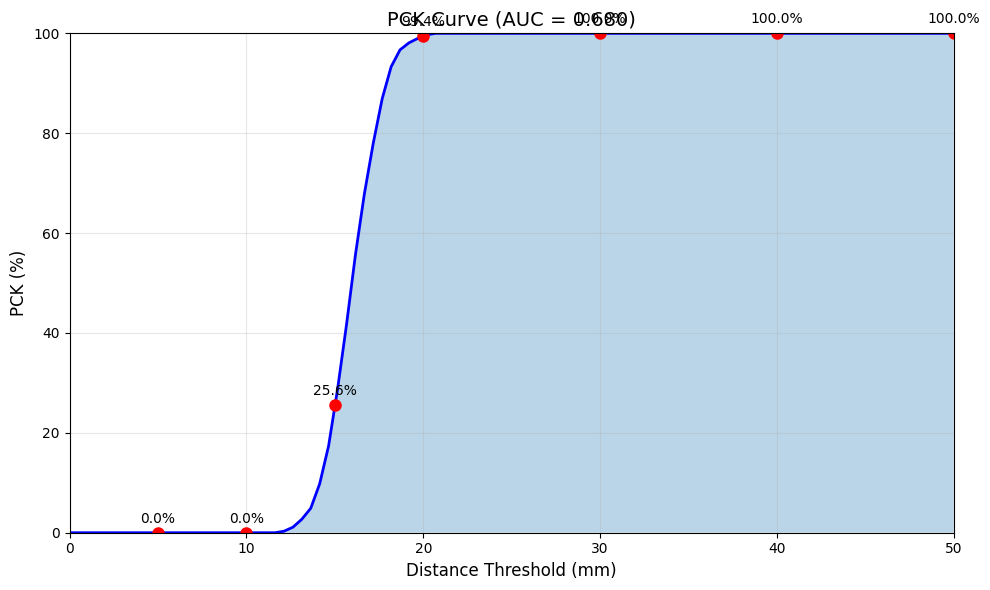

In [6]:
# Visualization 1: PCK Curve
plt.figure(figsize=(10, 6))
plt.plot(auc_thresholds, auc_pck_values * 100, 'b-', linewidth=2)
plt.fill_between(auc_thresholds, 0, auc_pck_values * 100, alpha=0.3)
plt.xlabel('Distance Threshold (mm)', fontsize=12)
plt.ylabel('PCK (%)', fontsize=12)
plt.title(f'PCK Curve (AUC = {auc:.3f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(0, 50)
plt.ylim(0, 100)

# Add markers for specific thresholds
for threshold in thresholds:
    pck_val = pck_results[f'PCK@{threshold}mm']
    plt.plot(threshold, pck_val, 'ro', markersize=8)
    plt.text(threshold, pck_val + 2, f'{pck_val:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

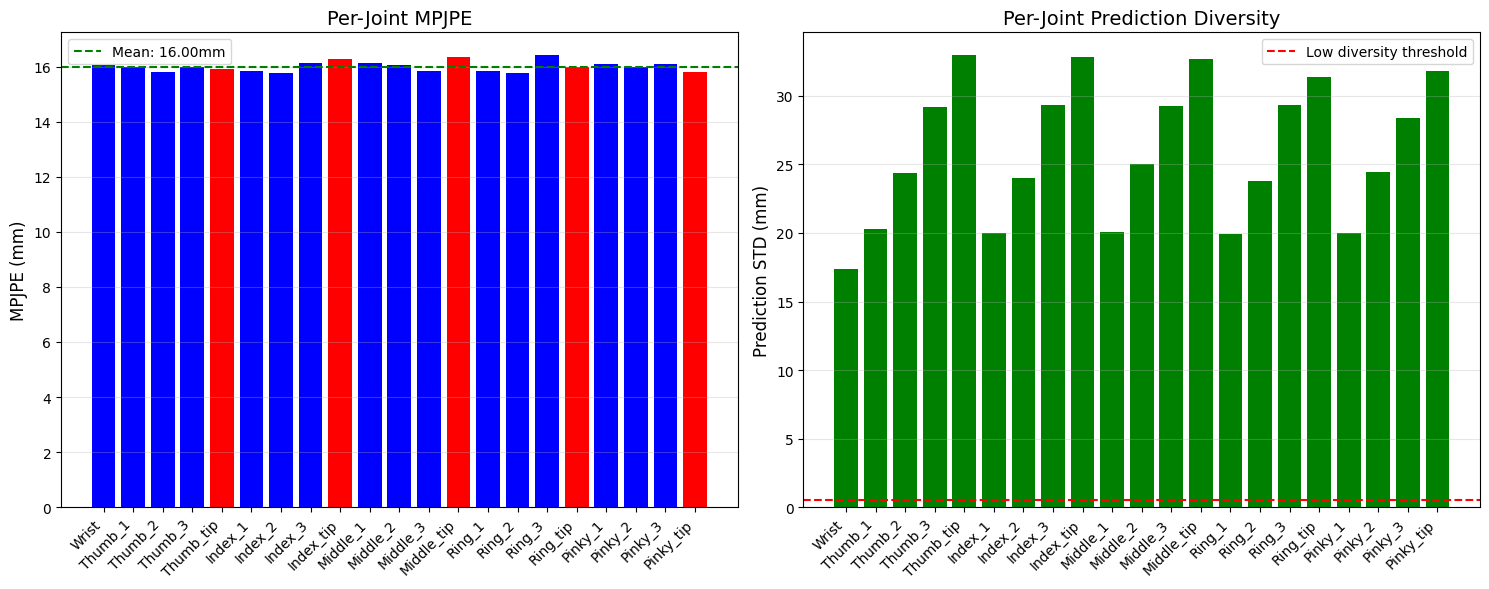

In [7]:
# Visualization 2: Per-Joint Error Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of per-joint errors
colors = ['red' if i in [4, 8, 12, 16, 20] else 'blue' for i in range(21)]  # Fingertips in red
bars = ax1.bar(range(21), per_joint_mpjpe, color=colors)
ax1.set_xticks(range(21))
ax1.set_xticklabels(joint_names, rotation=45, ha='right')
ax1.set_ylabel('MPJPE (mm)', fontsize=12)
ax1.set_title('Per-Joint MPJPE', fontsize=14)
ax1.grid(True, axis='y', alpha=0.3)
ax1.axhline(y=mpjpe_mean, color='green', linestyle='--', label=f'Mean: {mpjpe_mean:.2f}mm')
ax1.legend()

# Diversity per joint
std_magnitude = np.linalg.norm(diversity_metrics['std_per_joint'], axis=1)
bars2 = ax2.bar(range(21), std_magnitude, color='green')
ax2.set_xticks(range(21))
ax2.set_xticklabels(joint_names, rotation=45, ha='right')
ax2.set_ylabel('Prediction STD (mm)', fontsize=12)
ax2.set_title('Per-Joint Prediction Diversity', fontsize=14)
ax2.grid(True, axis='y', alpha=0.3)
ax2.axhline(y=0.5, color='red', linestyle='--', label='Low diversity threshold')
ax2.legend()

plt.tight_layout()
plt.show()

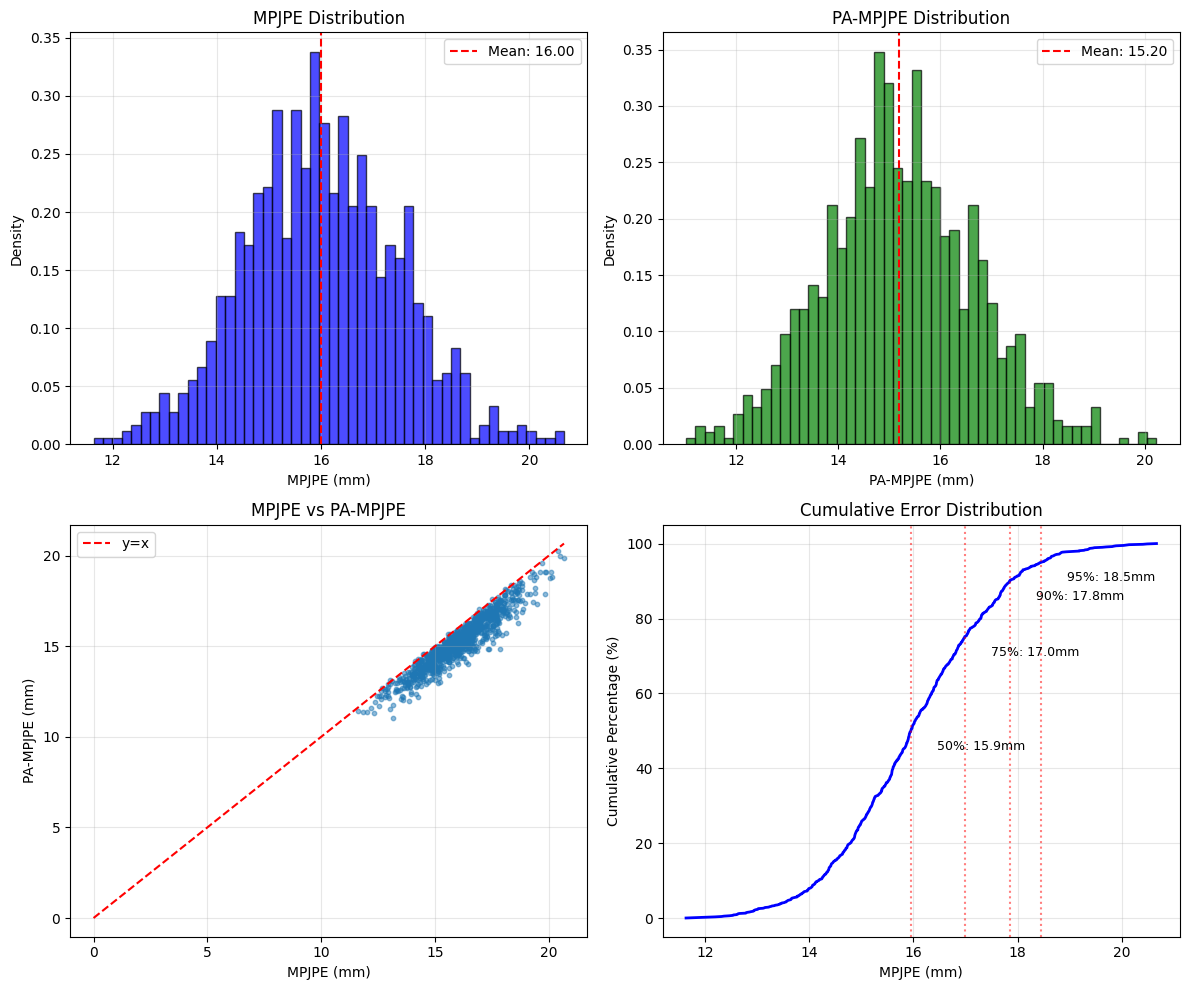

In [8]:
# Visualization 3: Error Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MPJPE distribution
sample_mpjpe = mpjpe_errors.mean(axis=1)
axes[0, 0].hist(sample_mpjpe, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(mpjpe_mean, color='red', linestyle='--', label=f'Mean: {mpjpe_mean:.2f}')
axes[0, 0].set_xlabel('MPJPE (mm)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('MPJPE Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# PA-MPJPE distribution
axes[0, 1].hist(pa_mpjpe_errors, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(pa_mpjpe_mean, color='red', linestyle='--', label=f'Mean: {pa_mpjpe_mean:.2f}')
axes[0, 1].set_xlabel('PA-MPJPE (mm)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('PA-MPJPE Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MPJPE vs PA-MPJPE scatter
axes[1, 0].scatter(sample_mpjpe, pa_mpjpe_errors, alpha=0.5, s=10)
max_val = max(sample_mpjpe.max(), pa_mpjpe_errors.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', label='y=x')
axes[1, 0].set_xlabel('MPJPE (mm)')
axes[1, 0].set_ylabel('PA-MPJPE (mm)')
axes[1, 0].set_title('MPJPE vs PA-MPJPE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative error distribution
sorted_mpjpe = np.sort(sample_mpjpe)
cumulative = np.arange(1, len(sorted_mpjpe) + 1) / len(sorted_mpjpe) * 100
axes[1, 1].plot(sorted_mpjpe, cumulative, 'b-', linewidth=2)
axes[1, 1].set_xlabel('MPJPE (mm)')
axes[1, 1].set_ylabel('Cumulative Percentage (%)')
axes[1, 1].set_title('Cumulative Error Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add percentile markers
percentiles = [50, 75, 90, 95]
for p in percentiles:
    val = np.percentile(sample_mpjpe, p)
    axes[1, 1].axvline(val, color='red', linestyle=':', alpha=0.5)
    axes[1, 1].text(val + 0.5, p - 5, f'{p}%: {val:.1f}mm', fontsize=9)

plt.tight_layout()
plt.show()

In [9]:
# Test mode collapse scenario
print("\n" + "="*60)
print("Testing Mode Collapse Scenario")
print("="*60)

# Generate data with mode collapse
pred_collapse, gt_collapse = generate_sample_data(n_samples=1000, noise_level=10.0, mode_collapse=True)

# Compute metrics
mpjpe_collapse = compute_mpjpe(pred_collapse, gt_collapse).mean()
diversity_collapse = compute_diversity(pred_collapse)

print(f"\nMode Collapse Results:")
print(f"  MPJPE: {mpjpe_collapse:.2f} mm")
print(f"  Mean STD per joint: {diversity_collapse['mean_std_per_joint']:.4f} mm")
print(f"  Min distance between predictions: {diversity_collapse['min_min_distance']:.4f} mm")

if diversity_collapse['mean_std_per_joint'] < 0.5:
    print("  ❌ Mode collapse confirmed - all predictions are nearly identical!")

# Compare normal vs collapsed
print("\nComparison:")
print(f"  Normal diversity: {diversity_metrics['mean_std_per_joint']:.4f} mm")
print(f"  Collapsed diversity: {diversity_collapse['mean_std_per_joint']:.4f} mm")
print(f"  Ratio: {diversity_metrics['mean_std_per_joint'] / diversity_collapse['mean_std_per_joint']:.1f}x")


Testing Mode Collapse Scenario

Mode Collapse Results:
  MPJPE: 16.18 mm
  Mean STD per joint: 0.0998 mm
  Min distance between predictions: 0.7133 mm
  ❌ Mode collapse confirmed - all predictions are nearly identical!

Comparison:
  Normal diversity: 14.4795 mm
  Collapsed diversity: 0.0998 mm
  Ratio: 145.1x


In [10]:
# Summary Report
print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Dataset size: {len(pred_joints)} samples")
print(f"\nKey Metrics:")
print(f"  - MPJPE: {mpjpe_mean:.2f} ± {mpjpe_std:.2f} mm")
print(f"  - PA-MPJPE: {pa_mpjpe_mean:.2f} ± {pa_mpjpe_std:.2f} mm")
print(f"  - PCK@20mm: {pck_results['PCK@20mm']:.2f}%")
print(f"  - AUC (0-50mm): {auc:.3f}")
print(f"  - Diversity: {diversity_metrics['mean_std_per_joint']:.4f} mm")

print("\nPerformance Assessment:")
if mpjpe_mean < 20:
    print("  ✅ Excellent performance (MPJPE < 20mm)")
elif mpjpe_mean < 50:
    print("  ✓ Good performance (MPJPE < 50mm)")
elif mpjpe_mean < 100:
    print("  ⚠️ Moderate performance (MPJPE < 100mm)")
else:
    print("  ❌ Poor performance (MPJPE > 100mm)")

if diversity_metrics['mean_std_per_joint'] < 0.5:
    print("  ❌ Mode collapse detected (low diversity)")
else:
    print("  ✅ Good prediction diversity")

print("="*60)


EVALUATION SUMMARY
Dataset size: 1000 samples

Key Metrics:
  - MPJPE: 16.00 ± 1.47 mm
  - PA-MPJPE: 15.20 ± 1.47 mm
  - PCK@20mm: 99.40%
  - AUC (0-50mm): 0.680
  - Diversity: 14.4795 mm

Performance Assessment:
  ✅ Excellent performance (MPJPE < 20mm)
  ✅ Good prediction diversity


In [11]:
# Function to load and evaluate your actual model predictions
def evaluate_predictions(pred_file: str, gt_file: str) -> Dict:
    """
    Load predictions and ground truth from files and compute all metrics
    
    Args:
        pred_file: Path to predictions file (numpy .npy or .npz)
        gt_file: Path to ground truth file
    
    Returns:
        results: Dictionary with all computed metrics
    """
    # Load data
    predictions = np.load(pred_file)
    ground_truth = np.load(gt_file)
    
    # Ensure correct shape [N, 21, 3]
    if predictions.ndim == 2:
        predictions = predictions.reshape(-1, 21, 3)
    if ground_truth.ndim == 2:
        ground_truth = ground_truth.reshape(-1, 21, 3)
    
    # Compute all metrics
    mpjpe_errors = compute_mpjpe(predictions, ground_truth)
    pa_mpjpe_errors = compute_pa_mpjpe(predictions, ground_truth)
    pck_results = compute_pck(mpjpe_errors, [5, 10, 15, 20, 30, 40, 50])
    auc, _, _ = compute_auc(mpjpe_errors, 0, 50)
    diversity = compute_diversity(predictions)
    
    results = {
        'mpjpe': mpjpe_errors.mean(),
        'mpjpe_std': mpjpe_errors.mean(axis=1).std(),
        'pa_mpjpe': pa_mpjpe_errors.mean(),
        'pa_mpjpe_std': pa_mpjpe_errors.std(),
        'pck': pck_results,
        'auc': auc,
        'diversity': diversity,
        'per_joint_mpjpe': mpjpe_errors.mean(axis=0)
    }
    
    return results

# Example usage (uncomment and modify paths when you have actual data):
# results = evaluate_predictions('path/to/predictions.npy', 'path/to/ground_truth.npy')
# print(f"MPJPE: {results['mpjpe']:.2f} mm")